<a href="https://colab.research.google.com/github/JimKing100/SF_Real_Estate_Project/blob/master/SF%20Map%20Code%20Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install libgeos
%%capture
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

In [0]:
# Install fiona
%%capture
!pip install fiona

In [0]:
# Install geopy
%%capture
!pip install geopy

In [0]:
# Install pysal
%%capture
!pip install -U pysal

In [0]:
# Step 1 libspatialindex install
!apt-get install -qq curl g++ make

In [0]:
# Step 2 libspatialindex install
%%capture
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

In [0]:
# Step 3 libspatialindex install
import os
os.chdir('spatialindex-src-1.8.5')

In [0]:
# Step 4 libspatialindex install
%%capture
!./configure

In [0]:
# Step 5 libspatialindex install
%%capture
!make

In [0]:
# Step 6 libspatialindex install
%%capture
!make install

In [0]:
# Step 7 libspatialindex install
%%capture
!pip install rtree

In [0]:
# Step 8 libspatialindex install
!ldconfig

In [0]:
# Import libraries
import pandas as pd
import numpy as np

from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain
from geopy.geocoders import Nominatim
import fiona
import matplotlib.pyplot as plt

from pysal.viz.mapclassify import Natural_Breaks as nb

In [20]:
# Load SF real estate data
initial_data = pd.read_csv('https://raw.githubusercontent.com/JimKing100/SF_Real_Estate_Project/master/data/SF-SFR-Sales-Final1.csv')
print(initial_data.shape)
initial_data.head(5)

(23711, 30)


,longitude,latitude,full_address,city,state,street_no,street_name,street_nox,street_suffix,zip,area,district_no,district_desc,subdist_no,subdist_desc,on_market_data,cdom,orig_list_price,sale_date,sale_price,rooms,baths,beds,sf_source,sf_source_decs,sf,lot_acres,lot_sf,year_built,zoning
0,-122.466620,37.753273,"1878 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1878,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,8/31/11,65,649000,12/22/11,580000,6,1.0,2,T,Per Tax Records,1480,NaN,0,1932,RH1
1,-122.466670,37.753850,"1842 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1842,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,10/8/08,164,679000,3/23/09,509000,0,1.0,2,T,Per Tax Records,920,NaN,0,1908,RH1
2,-122.466700,37.754070,"1829 10th Ave, San Francisco, CA 94122",San Francisco,CA,1829,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,9/6/13,15,699000,10/11/13,840000,0,1.5,2,T,Per Tax Records,1200,0.0693,3017,1906,RH1
3,-122.466965,37.758057,"1612 10th Ave, San Francisco, CA 94122",San Francisco,CA,1612,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,6/8/10,9,699900,7/29/10,817000,6,1.0,3,T,Per Tax Records,1800,NaN,0,1914,NaN
4,-122.466910,37.757130,"1671 10th Ave, San Francisco, CA 94122",San Francisco,CA,1671,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,9/8/11,25,749000,10/6/11,785000,5,1.0,2,T,Per Tax Records,1050,NaN,0,1938,RH2


In [21]:
# Rename subdistr_desc to neighborhood
temp_data = initial_data.rename(columns={'subdist_desc': 'neighborhood'})
temp_data.head(5)

,longitude,latitude,full_address,city,state,street_no,street_name,street_nox,street_suffix,zip,area,district_no,district_desc,subdist_no,neighborhood,on_market_data,cdom,orig_list_price,sale_date,sale_price,rooms,baths,beds,sf_source,sf_source_decs,sf,lot_acres,lot_sf,year_built,zoning
0,-122.466620,37.753273,"1878 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1878,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,8/31/11,65,649000,12/22/11,580000,6,1.0,2,T,Per Tax Records,1480,NaN,0,1932,RH1
1,-122.466670,37.753850,"1842 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1842,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,10/8/08,164,679000,3/23/09,509000,0,1.0,2,T,Per Tax Records,920,NaN,0,1908,RH1
2,-122.466700,37.754070,"1829 10th Ave, San Francisco, CA 94122",San Francisco,CA,1829,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,9/6/13,15,699000,10/11/13,840000,0,1.5,2,T,Per Tax Records,1200,0.0693,3017,1906,RH1
3,-122.466965,37.758057,"1612 10th Ave, San Francisco, CA 94122",San Francisco,CA,1612,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,6/8/10,9,699900,7/29/10,817000,6,1.0,3,T,Per Tax Records,1800,NaN,0,1914,NaN
4,-122.466910,37.757130,"1671 10th Ave, San Francisco, CA 94122",San Francisco,CA,1671,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,9/8/11,25,749000,10/6/11,785000,5,1.0,2,T,Per Tax Records,1050,NaN,0,1938,RH2


In [23]:
# Map MLS neighborhood code (e.g. 1010) to shapefile neighborhood id (e.g. '1a')
neighborhood_dict = {1010: '1a', 1020: '1b', 1030: '1c', 1040: '1d', 1050: '1e', 1060: '1f', 1070: '1g',
                     2010: '2a', 2020: '2b', 2030: '2c', 2040: '2d', 2050: '2e', 2060: '2f', 2070: '2g',
                     3010: '3a', 3020: '3b', 3030: '3c', 3040: '3d', 3050: '3e', 3060: '3f', 3070: '3g', 3080: '3h', 3090: '3j',
                     4010: '4a', 4020: '4b', 4030: '4c', 4040: '4d', 4050: '4e', 4060: '4f', 4070: '4g', 4080: '4h', 4090: '4j', 4100: '4k', 4110: '4m', 4120: '4n', 4130: '4p', 4140: '4r', 4150: '4s', 4160: '4t',
                     5010: '5a', 5020: '5b', 5030: '5c', 5040: '5d', 5050: '5e', 5060: '5f', 5070: '5g', 5080: '5h', 5090: '5j', 5100: '5k', 5110: '5m',
                     6010: '6a', 6020: '6b', 6030: '6c', 6040: '6d', 6050: '6e', 6060: '6f',
                     7010: '7a', 7020: '7b', 7030: '7c', 7040: '7d', 
                     8010: '8a',             8030: '8c', 8040: '8d', 8050: '8e', 8060: '8f', 8070: '8g', 8080: '8h', 8090: '8j',
                     9010: '9a', 9020: '9c', 9030: '9d', 9040: '9e', 9050: '9f', 9060: '9h', 9070: '9j', 9080: '9g', 
                     10010: '10a', 10020: '10b', 10030: '10c', 10040: '10d', 10050: '10e', 10060: '10f', 10070: '10g', 10080: '10h', 10090: '10j', 10100: '10k', 10110: '10m', 10120: '10n'
                    }
sf_data = temp_data.replace({"subdist_no": neighborhood_dict})
sf_data.head(5)
# Change the neighborhood to match the maps neighborhood 
# sf_data['neighborhood'] = sf_data['neighborhood'].str[4:]

,longitude,latitude,full_address,city,state,street_no,street_name,street_nox,street_suffix,zip,area,district_no,district_desc,subdist_no,neighborhood,on_market_data,cdom,orig_list_price,sale_date,sale_price,rooms,baths,beds,sf_source,sf_source_decs,sf,lot_acres,lot_sf,year_built,zoning
0,-122.466620,37.753273,"1878 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1878,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,8/31/11,65,649000,12/22/11,580000,6,1.0,2,T,Per Tax Records,1480,NaN,0,1932,RH1
1,-122.466670,37.753850,"1842 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1842,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,10/8/08,164,679000,3/23/09,509000,0,1.0,2,T,Per Tax Records,920,NaN,0,1908,RH1
2,-122.466700,37.754070,"1829 10th Ave, San Francisco, CA 94122",San Francisco,CA,1829,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,9/6/13,15,699000,10/11/13,840000,0,1.5,2,T,Per Tax Records,1200,0.0693,3017,1906,RH1
3,-122.466965,37.758057,"1612 10th Ave, San Francisco, CA 94122",San Francisco,CA,1612,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,6/8/10,9,699900,7/29/10,817000,6,1.0,3,T,Per Tax Records,1800,NaN,0,1914,NaN
4,-122.466910,37.757130,"1671 10th Ave, San Francisco, CA 94122",San Francisco,CA,1671,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,9/8/11,25,749000,10/6/11,785000,5,1.0,2,T,Per Tax Records,1050,NaN,0,1938,RH2


In [24]:
# Create summary data by neighborhood
neighborhood_data = pd.DataFrame({'price_sf': sf_data.groupby('subdist_no').apply(
                                   lambda x: sum(x['sale_price'])/sum(x['sf']))})

# Initialize the data in case there is no data 
neighborhood_data.loc['8b'] = [1]
neighborhood_data.loc['8h'] = [1]
neighborhood_data.loc['9d'] = [1]
neighborhood_data.loc['12a'] = [1]
neighborhood_data.loc['12b'] = [1]
neighborhood_data.loc['12c'] = [1]

neighborhood_data.sort_values(by=['subdist_no'])

,price_sf
subdist_no,
10a,415.417979
10b,522.064080
10c,586.687555
10d,530.954830
10e,452.118785
10f,545.447338
10g,510.475123
10h,630.432633
10j,273.087373


In [0]:
# Set 0 values in square foot (sf) to NaN
# sf_data['sf'].replace(0, np.nan, inplace=True)
# sf_data.head()

In [0]:
#for i in range(1000, 1400):
#  geolocator = Nominatim(user_agent='Test')
#  location = geolocator.geocode(sf_data.loc[i, 'full_address'], timeout=None)
#  if location:
#    sf_data.loc[i, 'latitude'] = location.latitude
#    sf_data.loc[i, 'longitude'] = location.longitude

In [0]:
# Download the geo files from github
%%capture
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp?raw=true'
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.dbf?raw=true'
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.prj?raw=true'
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shx?raw=true'

In [0]:
# Rename the geofiles
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.dbf?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.dbf
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.prj?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.prj
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shx?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shx

In [0]:
# Load the geo files
shp = fiona.open('/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp')

In [0]:
# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [0]:
# Create the basemap
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(92,
 5,
 [-122.51494807968153, 37.70808933741858, 0.0, 0.0],
 [-122.35696603928594, 37.811573987414484, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7f3e59449c18>)

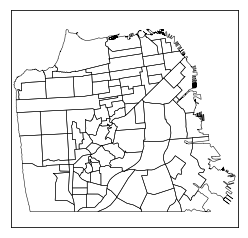

In [31]:
# Read the shape file
m.readshapefile(
    '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898',
    'SF',
    color='black',
    zorder=2)

In [0]:
# Change parks to non-existing MLS region 12 in shape file
m.SF_info[24]['nid'] = '12a' # Golden Gate Park
m.SF_info[73]['nid'] = '12b' # Presidio
m.SF_info[91]['nid'] = '12c' # Lincoln Park

In [33]:
# Fill the map dataframe with values
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'nbrhood_name': [nbrhood['nbrhood'] for nbrhood in m.SF_info],
    'nid': [nid['nid'] for nid in m.SF_info],
    'price_sf': [neighborhood_data.loc[nid['nid'], 'price_sf'] for nid in m.SF_info]
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#808080',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))

df_map.head()

#print(df_map['nbrhood_name'].unique().tolist())
#print(sf_data['neighborhood'].unique().tolist())
#pd.set_option('max_rows', 100)

,poly,nbrhood_name,nid,price_sf,area_m,area_km,patches
0,"POLYGON ((7715.167703048319 8393.557469683687,...",Alamo Square,6e,809.780584,3.245940e+05,3.245940,"PathPatch16((7715.17, 8393.56) ...)"
1,"POLYGON ((6133.610085287233 8930.101370827508,...",Anza Vista,6a,683.228584,2.888324e+05,2.888324,"PathPatch10((6133.61, 8930.1) ...)"
2,"POLYGON ((4605.819118328618 3648.076924674302,...",Balboa Terrace,4a,719.214567,2.185278e+05,2.185278,"PathPatch23((4605.82, 3648.08) ...)"
3,"POLYGON ((11395.04759510169 5621.170830157842,...",Bayview,10a,415.417979,5.015361e+06,50.153607,"PathPatch562((11395, 5621.17) ...)"
4,"POLYGON ((9969.501990147706 5508.065990637874,...",Bernal Heights,9a,989.012567,2.827494e+06,28.274940,"PathPatch61((9969.5, 5508.07) ...)"


In [0]:
#Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(sf_data['longitude'],sf_data['latitude'])])
plt_points = MultiPoint(list(map_points.values))
    

<Figure size 432x288 with 0 Axes>

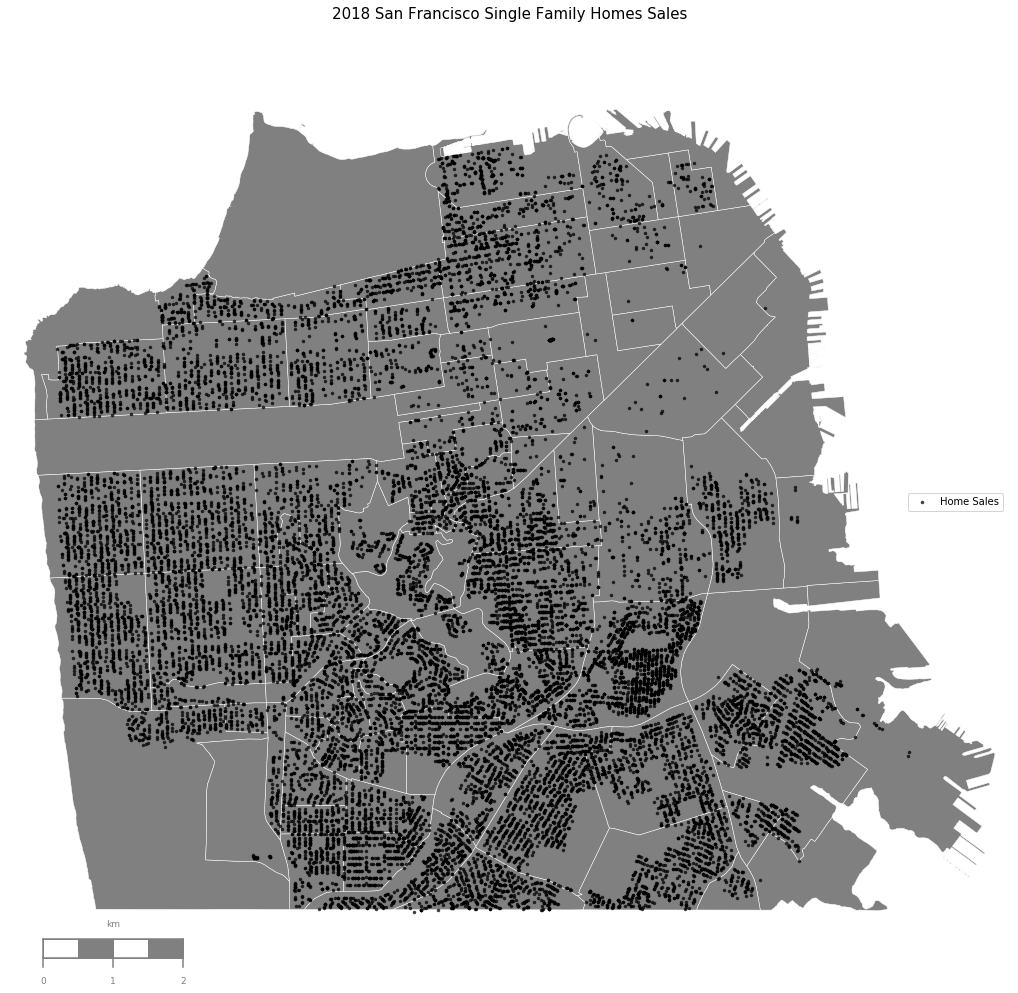

In [35]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)

dev = m.scatter(
    [geom.x for geom in map_points],
    [geom.y for geom in map_points],
    10, marker='o', lw=.25,
    facecolor='black', edgecolor='black',
    alpha=0.75, antialiased=True,
    label='Home Sales', zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#808080',
    fontcolor='#808080',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("2018 San Francisco Single Family Homes Sales", size=15)
fig.set_size_inches(15,15)
plt.show()

In [56]:
# Calculate Jenks natural breaks for price_sf
breaks = nb(
    df_map[df_map['price_sf'].notnull()].price_sf.values,
    initial=300,
    k=10)

prev = 0
for pricesf, counts in zip(breaks.bins, breaks.counts):
    print(counts, prev, pricesf)
    prev = pricesf

/usr/local/lib/python3.6/dist-packages/pysal/viz/mapclassify/classifiers.py:482: UserWarning: Deprecated (2.1.0): Natural_Breaks is being renamed to NaturalBreaks. Natural_Breaks will be removed on 2020-01-31.
  warn(self.message)


6 0 1.0
6 1.0 419.7386221408466
11 419.7386221408466 593.0405364711473
25 593.0405364711473 773.7343886857194
16 773.7343886857194 945.7528010211317
9 945.7528010211317 1114.7560226189262
10 1114.7560226189262 1323.6376160068114
10 1323.6376160068114 1490.032184778493
5 1490.032184778493 1845.179717229425
2 1845.179717229425 2075.6825095301047


In [0]:
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['price_sf'].notnull()].index)
df_map.drop("jenks_bins", inplace=True, axis=1, errors="ignore")
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# assign labels to the colorbar based on the natural breaks bins
jenks_labels = ["<= %0.1f crimes / km$^2$" % b for b in breaks.bins]
jenks_labels.insert(0, 'No crimes')

<Figure size 432x288 with 0 Axes>

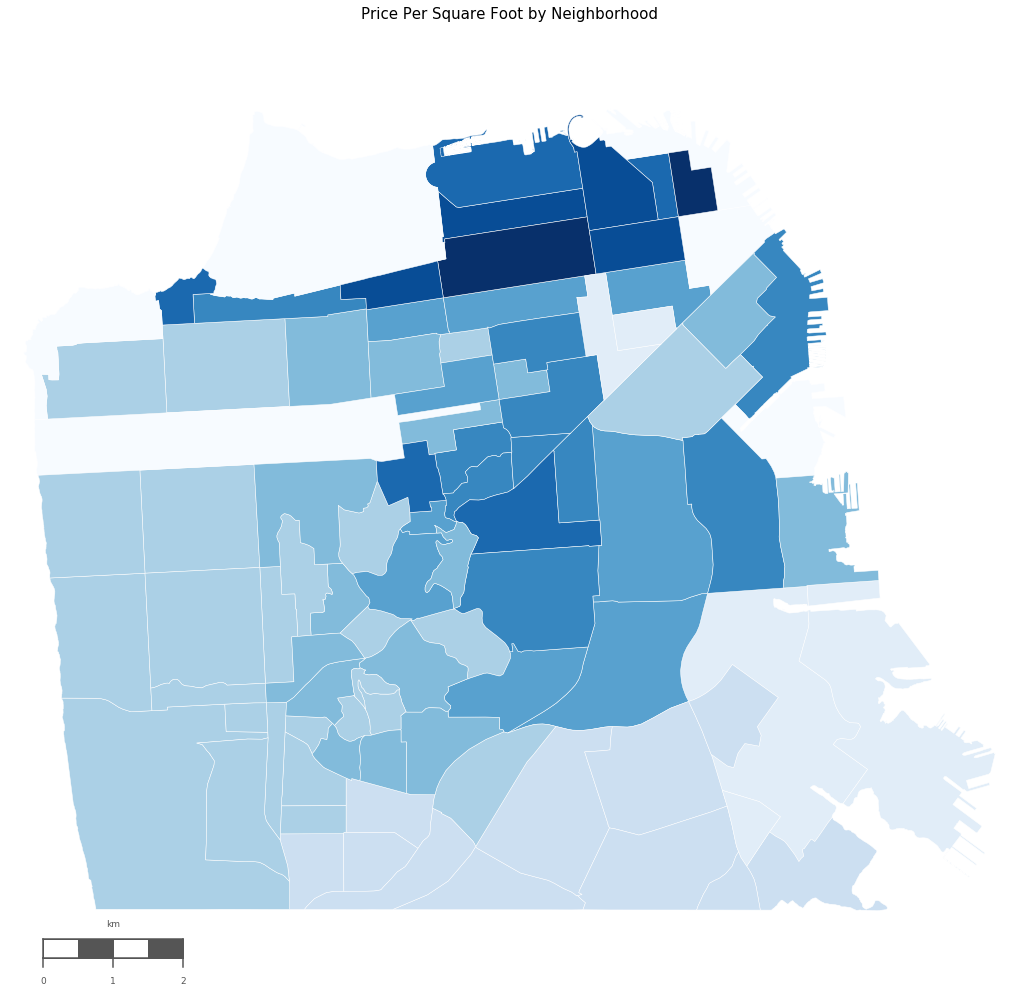

In [58]:
from matplotlib.colors import Normalize, LinearSegmentedColormap 

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

# Add a colour bar
#colorbar #_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
#colorbar.ax.tick_params(labelsize=10)

# Show highest densities, in descending order
#highest = '\n'.join(
#    value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
#highest = 'Most criminal neighborhoods:\n\n' + highest
#highest = 'Most criminal neighborhoods:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
#details = cb.ax.text(
#    -1., 0 + 0.3,
#    highest,
#    ha='right', va='bottom',
#    size=10,
#    color='#555555')

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.tight_layout()
plt.title("Price Per Square Foot by Neighborhood", size=15)
fig.set_size_inches(15, 15)
plt.show()